In [182]:
import matplotlib as mpl
import pyvista
import ufl
import numpy as np
from petsc4py import PETSc
from mpi4py import MPI
from dolfinx import fem, mesh, io, plot
from dolfinx.fem.petsc import assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc


In [183]:
# Van Genuchten parameters (example values)
import ufl.algebra


theta_s = 0.41
theta_r = 0.065
alpha = 0.075
n = 1.89
m = 1.0 - 1.0 / n
Ks = 4.42

# Functions
def saturation(Theta):
    return ufl.conditional(Theta >= theta_s, 
                           1.0, 
                           ufl.conditional(Theta <= theta_r, 
                                           0.0, 
                                           (Theta - theta_r) / (theta_s - theta_r)))
def moisture(h):
    return ufl.conditional(h>=0, 
                           theta_s, 
                           theta_r + (theta_s - theta_r)*(1+ (alpha*ufl.algebra.Abs(h))**n)**-m )

def head(Theta):
    Se = saturation(Theta)
    return ufl.conditional(Theta >= theta_s, 0.0,
                           -(1/alpha)*((Se**(-1/m)) -1)**(1/n))

def head_numpy(Theta):
    Se = (theta_s-Theta)/(theta_s-theta_r)
    return np.where(Theta >= theta_s, 
                    0.0,
                   - (1/alpha) * ((Se**(-1/m)) - 1)**(1/n)
                    )

def hydraulic_conductivity(h):
    Se = saturation(moisture(h))
    return ufl.conditional(h >=0, 
                           Ks, 
                           Ks * Se**(0.5) * (1 - (1 - Se**(1/m))**m)**2)

def capacity(h):
    return ufl.conditional(h >= 0, 
                           0.0,
                           (theta_s-theta_r)*m*n*alpha*(-alpha*h)**(n-1)*(1+(-alpha*h)**n)**(-(m+1)))




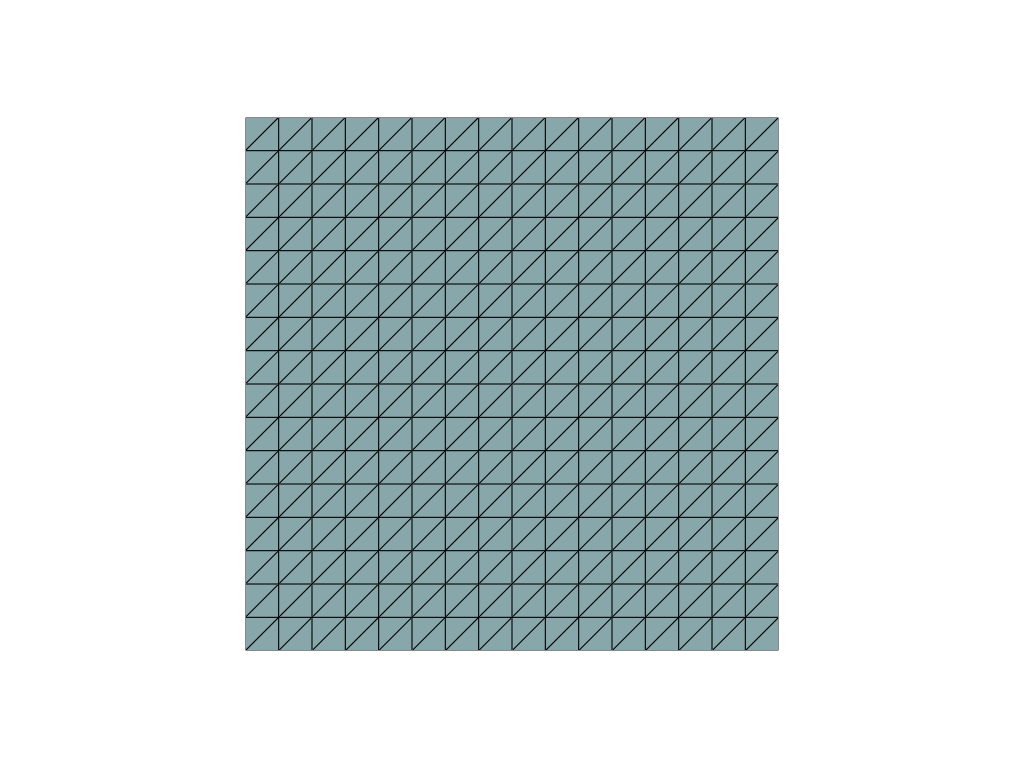

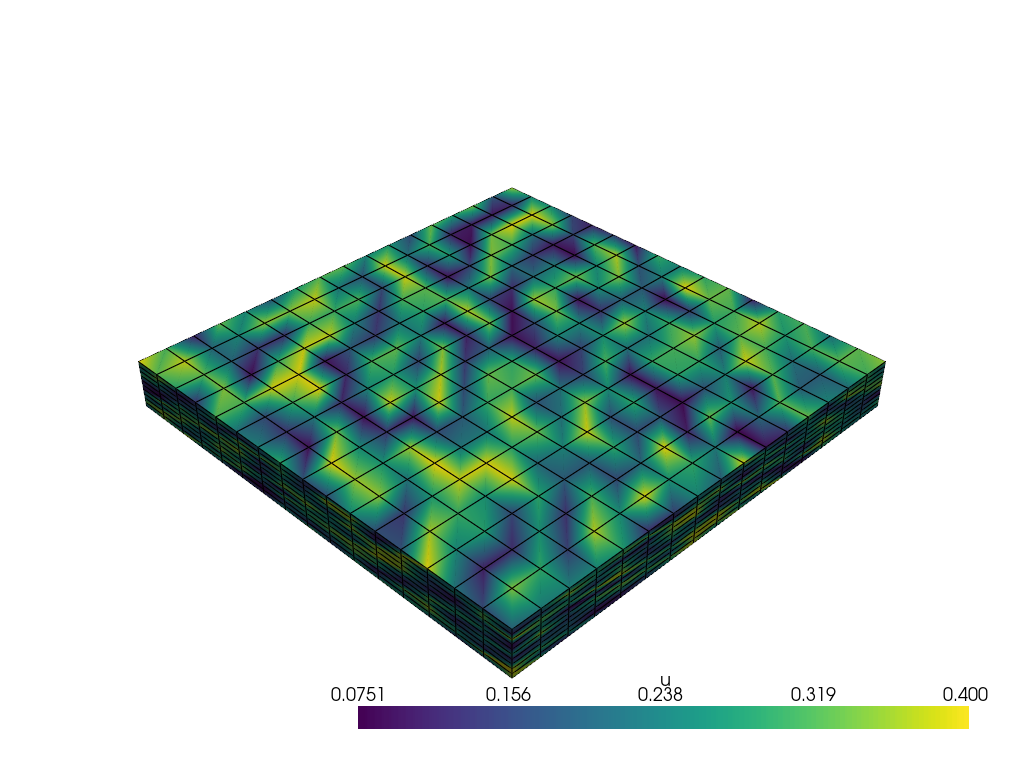

In [184]:
# Physical Dimensions
Lx,Ly,Lz = 2.85, 2.85, .3

# Mesh
nx, ny, nz = 16, 16, 10

domain = mesh.create_box(MPI.COMM_WORLD, 
                         [np.array([0, 0, 0]), np.array([Lx, Ly, Lz])], 
                         [nx, ny, nz], 
                         mesh.CellType.hexahedron)

# Function space
V = fem.functionspace(domain, ("CG", 1))
# Boundary condition

#Initial condition
theta_n = fem.Function(V)
theta_n.interpolate(lambda x: np.random.uniform(theta_r+0.01,theta_s-0.01, size=x.shape[1]))
#theta_n.interpolate(lambda x: np.full(x.shape[1], (theta_r + theta_s)/2))

h_n_expr = head_numpy(theta_n.x.array)
h_n =  fem.Function(V)
h_n.x.array[:] = h_n_expr


# Boundary conditions
tdim = domain.topology.dim
fdim = tdim - 1

def top_surface(x):
    return np.isclose(x[2], Lz)

domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
top_facets = mesh.locate_entities_boundary(domain, fdim, top_surface)
other_facets = np.setdiff1d(boundary_facets, top_facets)

# Top = 100
u_top = fem.Function(V)
u_top.interpolate(lambda x: np.random.uniform(head_numpy(theta_s-0.2), head_numpy(theta_s-0.001), size=x.shape[1]))
dofs_top = fem.locate_dofs_topological(V, fdim, top_facets)
bc_top = fem.dirichletbc(u_top, dofs_top)

# Others = 20
u_other = fem.Function(V)
u_other.interpolate(lambda x: np.full(x.shape[1], head_numpy(theta_r)))
dofs_other = fem.locate_dofs_topological(V, fdim, other_facets)
bc_other = fem.dirichletbc(u_other, dofs_other)
bcs = [bc_top, bc_other]

# Time parameters
K_expr = hydraulic_conductivity(h_n)
K_fun = fem.Function(V)
K_fun.interpolate(fem.Expression(K_expr, V.element.interpolation_points()))

#dt = (1/(2*np.max(K_fun.x.array.max())))* ((1/(Lx/(nx+1))**2)+(1/(Ly/(ny+1))**2)+ (1/(Lz/(nz+1))**2))**-1
dt = 3600
T = dt *100

# Visualization
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = theta_n.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)

# if not pyvista.OFF_SCREEN:
u_plotter.show()


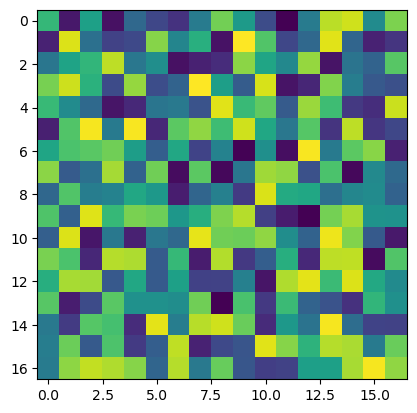

In [185]:
import matplotlib.pyplot as plt
theta_history_numpy = np.array(theta_n.x.array)
reshaped = theta_history_numpy.reshape(nx+1,ny+1,nz+1)
plt.imshow(reshaped[:,:,int((nz+1)/2)])

In [186]:
from dolfinx.fem.petsc import LinearProblem
t = 0.0
step = 0

max_iter = 1000
tol = 1e-3
z = ufl.SpatialCoordinate(domain)[2]
n_tilde = ufl.FacetNormal(domain)
h = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
plotter = pyvista.Plotter(shape= (1,3), off_screen=True)
plotter.open_gif("Richards.gif")
theta_history = [theta_n.x.array]
while t < T:
    print(f"Time step {step+1}, t = {t/3600:.2f} hours")
    h_k = fem.Function(V)  # current Picard iterate
    h_k.x.array[:] = h_n.x.array[:]  # start from last time step

    # Top = 100
    u_top = fem.Function(V)
    u_top.interpolate(lambda x: np.random.uniform(head_numpy(theta_s-0.2), head_numpy(theta_s-0.001), size=x.shape[1]))
    dofs_top = fem.locate_dofs_topological(V, fdim, top_facets)
    bc_top = fem.dirichletbc(u_top, dofs_top)
    bcs = [bc_top, bc_other]
    h = ufl.TrialFunction(V)

    for picard_iter in range(max_iter):
        C_k = capacity(h_n)
        K_k = hydraulic_conductivity(h_n)
        D = K_k/C_k
        # a = h*v*ufl.dx
        # L = h_k*v*ufl.dx- dt*D*ufl.dot(ufl.grad(h_k+z), ufl.grad(v))*ufl.dx + dt*D*ufl.dot(ufl.grad(h_k+z),n_tilde)*v*ufl.ds

        # problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "gmres", "pc_type": "hypre"})

        # Variational form
        F = (C_k * (h - h_k) / dt) * v * ufl.dx + K_k * ufl.dot(ufl.grad(h + z), ufl.grad(v)) * ufl.dx

        # Optional: Neumann/flux BCs here (if any)

        # Assemble and solve
        problem = fem.petsc.LinearProblem(ufl.lhs(F), ufl.rhs(F), bcs=bcs,
                                        petsc_options={"ksp_type": "gmres", "pc_type": "hypre"})
        h_sol = problem.solve()
        # Check convergence
        diff = np.linalg.norm(h_sol.x.array - h_k.x.array, ord=np.inf)
        print(f"  Picard iter {picard_iter+1}, residual: {diff:.3e}")
        h_k.x.array[:] = h_sol.x.array[:]

        if diff < tol:
            break
        else:
            print("  Picard did not converge!")
        
    step += 1
    
    # Update for next time step
    h_n.x.array[:] = h_k.x.array[:]
    theta_n.interpolate(fem.Expression(moisture(h_k), V.element.interpolation_points()))
    t += dt
    # Visualization
    u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
    u_grid.point_data["u"] = theta_n.x.array.real
    u_grid.set_active_scalars("u")
    slice_xy = u_grid.slice(normal='z', origin=(0, 0, 0.2))  # Mid-Z
    plotter.clear()

    plotter.subplot(0, 1)
    plotter.add_text("XY Slice", font_size=10)
    plotter.add_mesh(slice_xy, show_edges=False, cmap="jet", clim=(theta_r, theta_s))
    plotter.view_xy()

    # Save frame
    plotter.write_frame()
    print(theta_n.x.array.max())
    theta_history.append(theta_n.x.array)

plotter.close()


Time step 1, t = 0.00 hours
  Picard iter 1, residual: 9.440e+03
  Picard did not converge!
  Picard iter 2, residual: 3.392e-03
  Picard did not converge!
  Picard iter 3, residual: 2.544e-09
0.41
Time step 2, t = 1.00 hours
  Picard iter 1, residual: 3.733e+04
  Picard did not converge!
  Picard iter 2, residual: 1.138e+02
  Picard did not converge!
  Picard iter 3, residual: 1.409e+00
  Picard did not converge!
  Picard iter 4, residual: 1.691e-02
  Picard did not converge!
  Picard iter 5, residual: 2.140e-04
0.41
Time step 3, t = 2.00 hours
  Picard iter 1, residual: 7.393e+04
  Picard did not converge!
  Picard iter 2, residual: 5.813e+01
  Picard did not converge!
  Picard iter 3, residual: 4.751e-02
  Picard did not converge!
  Picard iter 4, residual: 5.533e-05
0.41
Time step 4, t = 3.00 hours
  Picard iter 1, residual: 1.284e+05
  Picard did not converge!
  Picard iter 2, residual: 8.266e+01
  Picard did not converge!
  Picard iter 3, residual: 2.612e-01
  Picard did not conv

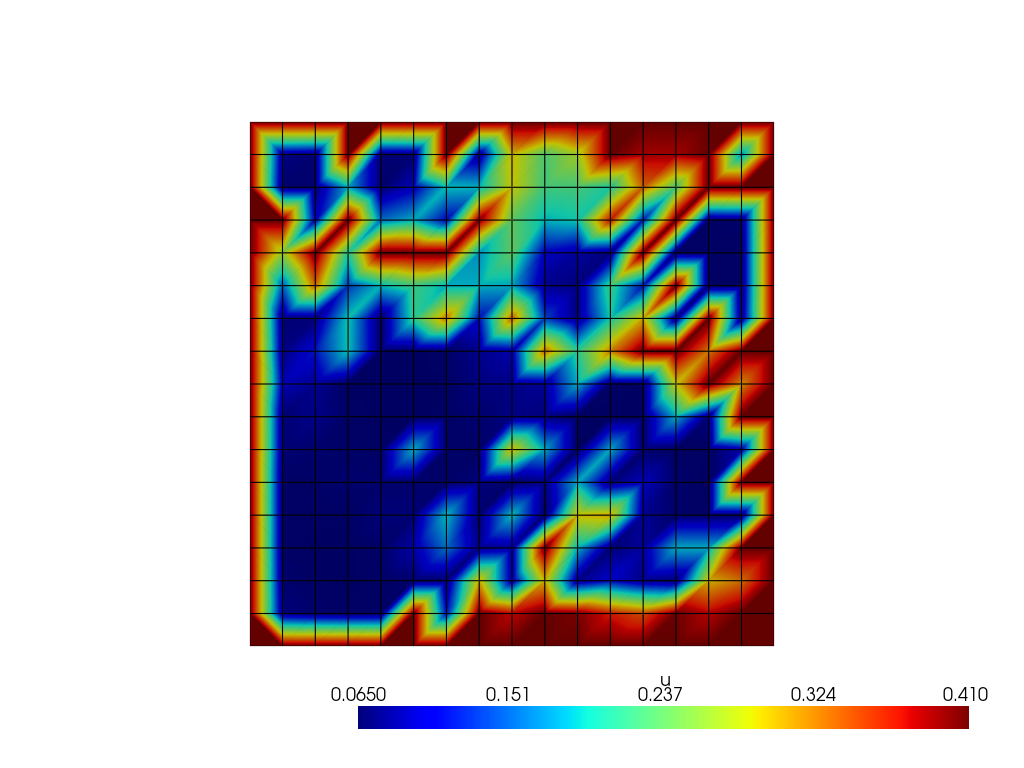

In [270]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = theta_n.x.array.real
u_grid.set_active_scalars("u")

# Slice at y = 0.5 (mid-Y)
slice_xz = u_grid.slice(normal='z', origin=(0, 0, 0.2))

# Plot the slice with fixed color limits
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(slice_xz, show_edges=True, cmap="jet", clim=(theta_r, theta_s))
u_plotter.view_xy()
u_plotter.show()

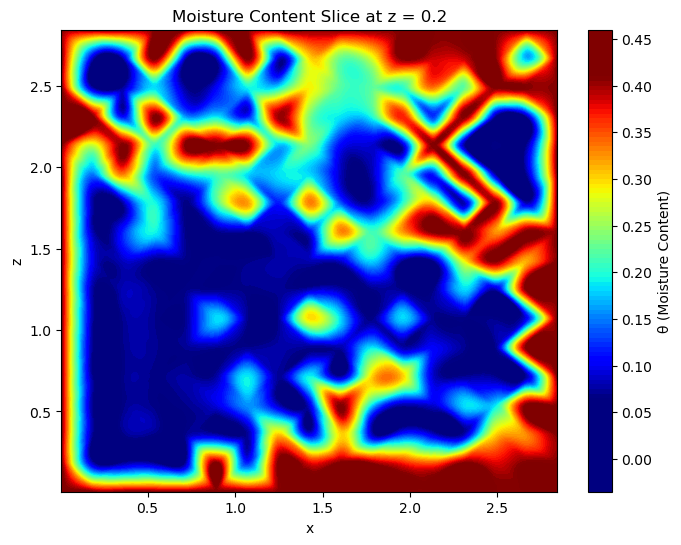

In [284]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Step 1: Get points and scalar values
coords = slice_xz.points  # shape: (N_points, 3)
theta_values = slice_xz["u"]

# Step 2: Use only X and Z coordinates (since Y is constant)
x = coords[:, 0]
z = coords[:, 1]

# Step 3: Create a regular grid in X-Z plane
xi = np.linspace(x.min(), x.max(), 200)
zi = np.linspace(z.min(), z.max(), 200)
X, Z = np.meshgrid(xi, zi)

# Step 4: Interpolate to the grid
theta_grid = griddata(
    (x, z),           # known points
    theta_values,     # known values
    (X, Z),           # grid to interpolate to
    method="cubic"   # or "nearest" or "cubic"
)

# Step 5: Plot using imshow
plt.figure(figsize=(8, 6))
im = plt.contourf(
    theta_grid,
    extent=(x.min(), x.max(), z.min(), z.max()),
    origin='lower',
    cmap='jet',
    vmin=theta_r,
    vmax=theta_s,
    aspect='auto',
    levels=100
)
plt.colorbar(im, label='θ (Moisture Content)')
plt.xlabel("x")
plt.ylabel("z")
plt.title("Moisture Content Slice at z = 0.2")
plt.show()



In [230]:
theta_history_numpy = np.array(theta_history)
theta_history_numpy.T.shape
reshaped_history = []
middle_z = int((nz+1)/2)
for i in range(theta_history_numpy.shape[0]):
    reshaped = theta_history_numpy[i,:].reshape(nx+1, ny+1, nz+1)
    sliced_data = reshaped[:,:,middle_z].flatten()
    reshaped_history.append(sliced_data)

In [236]:
reshaped_history_numpy = np.array(reshaped_history)
reshaped_history_numpy.shape
reshaped_history_numpy[1,:]

array([0.41      , 0.41      , 0.09335883, 0.41      , 0.41      ,
       0.41      , 0.41      , 0.41      , 0.41      , 0.41      ,
       0.41      , 0.41      , 0.07882241, 0.41      , 0.24358912,
       0.41      , 0.08554732, 0.41      , 0.41      , 0.41      ,
       0.41      , 0.40994308, 0.41      , 0.41      , 0.39738983,
       0.13834449, 0.07726416, 0.0672605 , 0.41      , 0.41      ,
       0.41      , 0.39314656, 0.15296501, 0.06809936, 0.41      ,
       0.41      , 0.41      , 0.41      , 0.40967938, 0.41      ,
       0.21243339, 0.0692159 , 0.41      , 0.41      , 0.0676322 ,
       0.41      , 0.06693712, 0.41      , 0.41      , 0.09398975,
       0.41      , 0.41      , 0.06774143, 0.41      , 0.06674217,
       0.10404511, 0.41      , 0.37877194, 0.39868166, 0.41      ,
       0.41      , 0.41      , 0.41      , 0.07336695, 0.06660359,
       0.06646946, 0.41      , 0.06618382, 0.37650043, 0.41      ,
       0.41      , 0.41      , 0.11248944, 0.41      , 0.41   

In [234]:
np.savetxt("richard_simulation_1.csv", reshaped_history_numpy, delimiter=",", fmt="%.6f")